In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
noisy_path = "../../../data/noisylabels/CIFAR-10_human.pt"
noisy_labels = {
    k: torch.tensor(v) for k, v in torch.load(noisy_path, weights_only=False).items()
}
keys_to_test = ["aggre_label", "random_label1", "worse_label"]

In [3]:
def load_memorization_results(scheduler="exponential", seeds=[1337, 42, 1]):
    results = dict()

    for seed in seeds:
        results.setdefault(seed, dict())
        for key in keys_to_test:
            try:
                memo_results = torch.load(
                    f"{scheduler}/memo_results_{key}_{seed}.pt", weights_only=False
                )
            except FileNotFoundError:
                if seed in results:
                    results.pop(seed)
                continue
            results[seed][key] = memo_results

    memo_results_mean = {}
    memo_results_unc = {}
    for key in keys_to_test:
        human_clean = []
        human_wrong = []
        synthetic_clean = []
        synthetic_wrong = []
        symmetric_clean = []
        symmetric_wrong = []
        pairflip_clean = []
        pairflip_wrong = []
        for seed in results.keys():
            human_clean.append(results[seed][key]["human"]["clean"])
            human_wrong.append(results[seed][key]["human"]["wrong"])
            synthetic_clean.append(results[seed][key]["synthetic"]["clean"])
            synthetic_wrong.append(results[seed][key]["synthetic"]["wrong"])
            if "symmetric" in results[seed][key]:
                symmetric_clean.append(results[seed][key]["symmetric"]["clean"])
                symmetric_wrong.append(results[seed][key]["symmetric"]["wrong"])
            if "pairflip" in results[seed][key]:
                pairflip_clean.append(results[seed][key]["pairflip"]["clean"])
                pairflip_wrong.append(results[seed][key]["pairflip"]["wrong"])
        human_clean = torch.tensor(human_clean)
        human_wrong = torch.tensor(human_wrong)
        synthetic_clean = torch.tensor(synthetic_clean)
        synthetic_wrong = torch.tensor(synthetic_wrong)
        symmetric_clean = torch.tensor(symmetric_clean)
        symmetric_wrong = torch.tensor(symmetric_wrong)
        pairflip_clean = torch.tensor(pairflip_clean)
        pairflip_wrong = torch.tensor(pairflip_wrong)
        memo_results_mean[key] = {
            "human": {"clean": human_clean.mean(0), "wrong": human_wrong.mean(0)},
            "synthetic": {
                "clean": synthetic_clean.mean(0),
                "wrong": synthetic_wrong.mean(0),
            },
        }
        if "symmetric" in results[seed][key]:
            memo_results_mean[key]["symmetric"] = {
                "clean": symmetric_clean.mean(0),
                "wrong": symmetric_wrong.mean(0),
            }
        if "pairflip" in results[seed][key]:
            memo_results_mean[key]["pairflip"] = {
                "clean": pairflip_clean.mean(0),
                "wrong": pairflip_wrong.mean(0),
            }
        memo_results_unc[key] = {
            "human": {
                "clean": human_clean.std(0) / np.sqrt(human_clean.shape[0]),
                "wrong": human_wrong.std(0) / np.sqrt(human_wrong.shape[0]),
            },
            "synthetic": {
                "clean": synthetic_clean.std(0) / np.sqrt(synthetic_clean.shape[0]),
                "wrong": synthetic_wrong.std(0) / np.sqrt(synthetic_wrong.shape[0]),
            },
        }
        if "symmetric" in results[seed][key]:
            memo_results_unc[key]["symmetric"] = {
                "clean": symmetric_clean.std(0) / np.sqrt(symmetric_clean.shape[0]),
                "wrong": symmetric_wrong.std(0) / np.sqrt(symmetric_wrong.shape[0]),
            }
        if "pairflip" in results[seed][key]:
            memo_results_unc[key]["pairflip"] = {
                "clean": pairflip_clean.std(0) / np.sqrt(pairflip_clean.shape[0]),
                "wrong": pairflip_wrong.std(0) / np.sqrt(pairflip_wrong.shape[0]),
            }
    return memo_results_mean, memo_results_unc

In [4]:
noise_type_name = {
    "synthetic": "Synthetic",
    "pairflip": "Pairflip",
    "symmetric": "Symmetric",
}


def visualize_memorization(
    memo_results_mean,
    memo_results_unc,
    synthetic_noise_type="synthetic",
    save_path=None,
):
    fig, ax = plt.subplots(2, 3, figsize=(10, 4))
    synthetic_label = noise_type_name[synthetic_noise_type]
    noise_names = {
        "aggre_label": "Aggregate",
        "random_label1": "Random 1",
        "worse_label": "Worst",
    }
    for i, key in enumerate(keys_to_test):
        ax[0, i].set_title(f"Clean labels ({noise_names[key]})")
        ax[0, i].plot(memo_results_mean[key]["human"]["clean"], "b", label="Real")
        ax[0, i].plot(
            memo_results_mean[key][synthetic_noise_type]["clean"],
            "b--",
            label=synthetic_label,
        )
        ax[0, i].fill_between(
            np.arange(150),
            memo_results_mean[key]["human"]["clean"]
            - memo_results_unc[key]["human"]["clean"],
            memo_results_mean[key]["human"]["clean"]
            + memo_results_unc[key]["human"]["clean"],
            color="b",
            alpha=0.2,
        )
        ax[0, i].fill_between(
            np.arange(150),
            memo_results_mean[key][synthetic_noise_type]["clean"]
            - memo_results_unc[key][synthetic_noise_type]["clean"],
            memo_results_mean[key][synthetic_noise_type]["clean"]
            + memo_results_unc[key][synthetic_noise_type]["clean"],
            color="b",
            alpha=0.2,
        )

        ax[1, i].set_title(f"Wrong labels ({noise_names[key]})")
        ax[1, i].plot(memo_results_mean[key]["human"]["wrong"], "r", label="Real")
        ax[1, i].plot(
            memo_results_mean[key][synthetic_noise_type]["wrong"],
            "r--",
            label=synthetic_label,
        )

        ax[1, i].fill_between(
            np.arange(150),
            memo_results_mean[key]["human"]["wrong"]
            - memo_results_unc[key]["human"]["wrong"],
            memo_results_mean[key]["human"]["wrong"]
            + memo_results_unc[key]["human"]["wrong"],
            color="r",
            alpha=0.2,
        )

        ax[1, i].fill_between(
            np.arange(150),
            memo_results_mean[key][synthetic_noise_type]["wrong"]
            - memo_results_unc[key][synthetic_noise_type]["wrong"],
            memo_results_mean[key][synthetic_noise_type]["wrong"]
            + memo_results_unc[key][synthetic_noise_type]["wrong"],
            color="r",
            alpha=0.2,
        )

        ax[0, i].legend()
        ax[1, i].legend()
        ax[0, i].set_ylim(0, 1)
        ax[1, i].set_ylim(0, 1)

    fig.supxlabel("Epoch")
    fig.supylabel("Fraction of memorized samples")
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=600)
    plt.show()

In [5]:
memo_results_mean, memo_results_unc = load_memorization_results(scheduler="exponential")

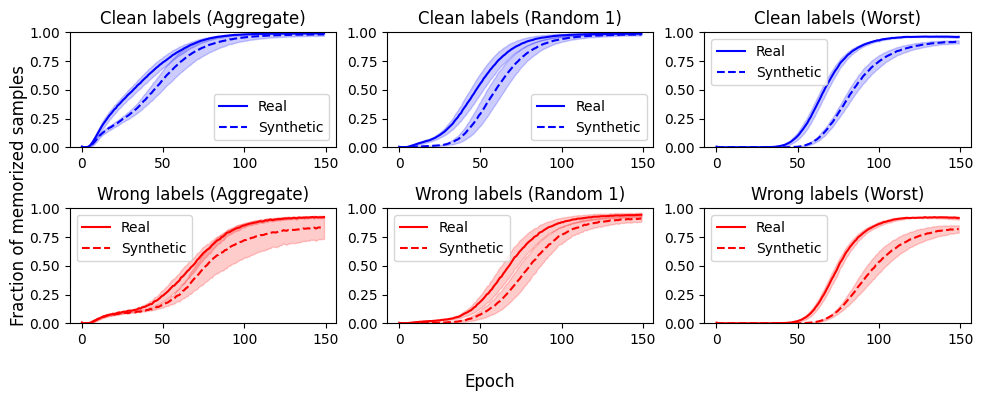

In [6]:
visualize_memorization(
    memo_results_mean,
    memo_results_unc,
    synthetic_noise_type="synthetic",
    save_path="memorization.pdf",
)

## Symmetric synthetic noise

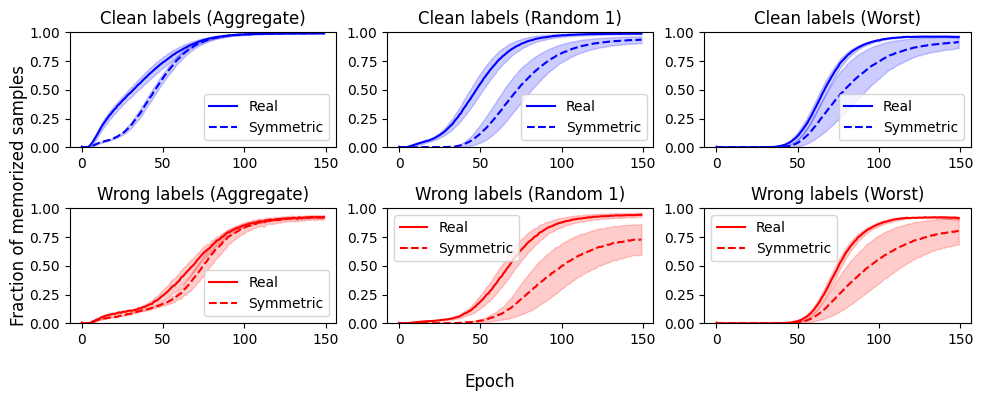

In [7]:
visualize_memorization(
    memo_results_mean,
    memo_results_unc,
    synthetic_noise_type="symmetric",
    save_path="memo_symmetric.pdf",
)

## Pairflip synthetic noise

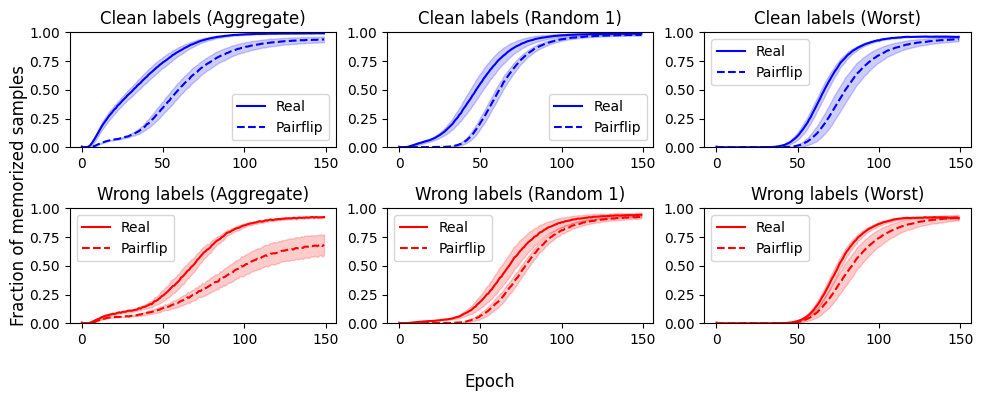

In [8]:
visualize_memorization(
    memo_results_mean,
    memo_results_unc,
    synthetic_noise_type="pairflip",
    save_path="memo_pairflip.pdf",
)

## Different Scheduler

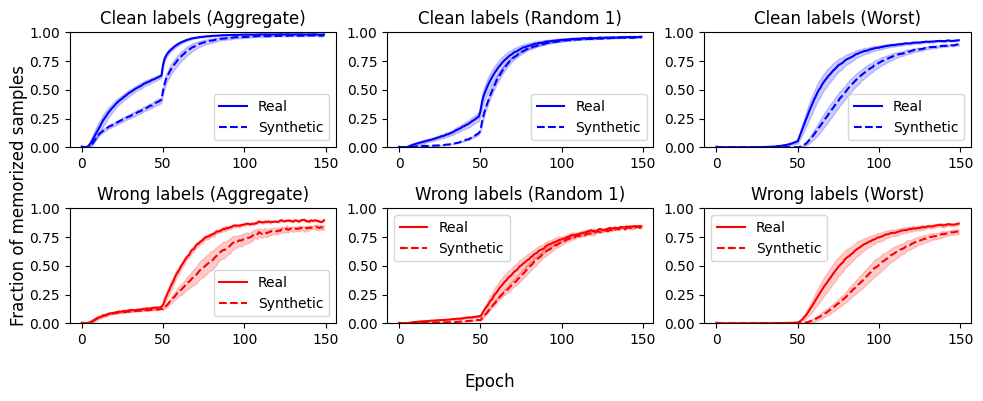

In [9]:
memo_results_mean, memo_results_unc = load_memorization_results(scheduler="step")
visualize_memorization(
    memo_results_mean,
    memo_results_unc,
    synthetic_noise_type="synthetic",
    save_path="memo_step_scheduler.pdf",
)

## Increased weight decay

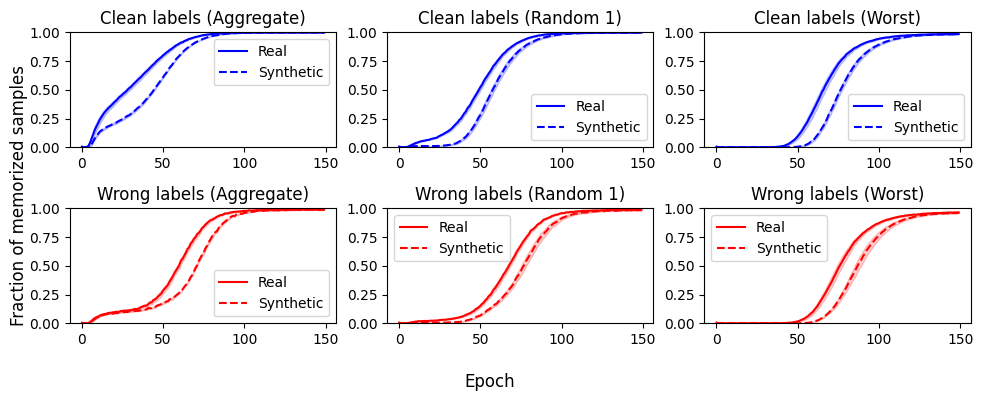

In [10]:
memo_results_mean, memo_results_unc = load_memorization_results(
    scheduler="exponential_wd_0.0005"
)
visualize_memorization(
    memo_results_mean,
    memo_results_unc,
    synthetic_noise_type="synthetic",
    save_path="memo_weight_decay.pdf",
)

## Lower learning rate

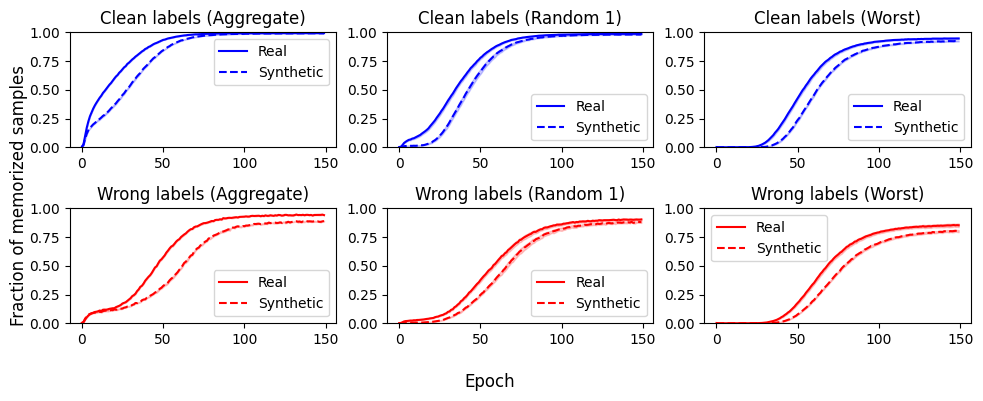

In [11]:
memo_results_mean, memo_results_unc = load_memorization_results(
    scheduler="exponential_lr_0.1"
)
visualize_memorization(
    memo_results_mean,
    memo_results_unc,
    synthetic_noise_type="synthetic",
    save_path="memo_learning_rate.pdf",
)